# Machine Learning - experimental project

**Author**:  Cagnin Beatrice

---

# Tree predictors for binary classification

---

In [20]:
import warnings
warnings.filterwarnings("ignore")   

In [21]:
import pandas as pd
import numpy as np
 
import matplotlib 
import matplotlib.pyplot as plt
%matplotlib inline

from ucimlrepo import fetch_ucirepo
from collections import Counter
import concurrent.futures

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score, validation_curve
from sklearn.metrics import zero_one_loss, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier

---

## Structures

#### Structure for the nodes

In [22]:
class TreeNode:
    
    def __init__(self, decision_function=None, left=None, right=None, is_leaf=False, prediction=None):    
        """
        TreeNode represents a node in the decision tree.
        """
        self.decision_function = decision_function  
        self.left = left                            
        self.right = right
        self.is_leaf = is_leaf                      
        self.prediction = prediction                
        
        
    def predict(self, x):
        """Recursively predicts the class for a data point x."""
        if self.is_leaf:                    
            return self.prediction
        if self.decision_function(x):       
            return self.left.predict(x)     
        else:
            return self.right.predict(x)    

#### Structure for the tree predictor

In [23]:
class DecisionTree:
    
    def __init__(self, splitting_criterion='gini', max_depth=None, min_samples_split=2):
        """
        Initialize the Decision Tree with a splitting criterion and two stopping criteria.
        """
        self.splitting_criterion = splitting_criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None
    
    
    def gini_impurity(self, y):
        """Calculate Gini impurity."""
        m = len(y)
        if m == 0:
            return 0
        p = np.bincount(y) / m
        return 1 - np.sum(p ** 2)    
    
    def entropy(self, y):
        """Calculate entropy."""
        m = len(y)
        if m == 0:
            return 0
        p = np.bincount(y) / m
        return -np.sum(p * np.log2(p + 1e-10))

    def squared_error(self, y):
        """Calculate squared error."""
        return np.mean((y - np.mean(y)) ** 2)

    
    def best_split(self, X, y):
        """Find the best feature and threshold for splitting."""
        best_feature, best_threshold = None, None
        best_score = float('inf')  
        
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] <= threshold
                right_indices = X[:, feature] > threshold

                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue

                if self.splitting_criterion == 'gini':
                    score = (self.gini_impurity(y[left_indices]) * np.sum(left_indices) +
                             self.gini_impurity(y[right_indices]) * np.sum(right_indices)) / len(y)
                elif self.splitting_criterion == 'entropy':
                    score = (self.entropy(y[left_indices]) * np.sum(left_indices) +
                             self.entropy(y[right_indices]) * np.sum(right_indices)) / len(y)
                elif self.splitting_criterion == 'squared_error':
                    score = (self.squared_error(y[left_indices]) * np.sum(left_indices) +
                             self.squared_error(y[right_indices]) * np.sum(right_indices)) / len(y)

                if score < best_score:
                    best_score = score
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    
    
    def stopping_criterion(self, X, y, depth):
        """Check if stopping criteria are met."""
        return ((self.max_depth is not None and depth >= self.max_depth) or 
                len(y) < self.min_samples_split)

        
    def _build_tree(self, X, y, depth=0):   
        """Recursively build the decision tree."""
        num_samples = len(y)

        if self.stopping_criterion(X, y, depth):                  
            prediction = max(set(y), key=list(y).count)           
            return TreeNode(is_leaf=True, prediction=prediction)

        best_feature, best_threshold = self.best_split(X, y)   

        if best_feature is None:                                  
            prediction = max(set(y), key=list(y).count)           
            return TreeNode(is_leaf=True, prediction=prediction)

        
        
        left_idx = X[:, best_feature] <= best_threshold           
        right_idx = X[:, best_feature] > best_threshold

        left_child = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_child = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        
        decision_function = lambda x: x[best_feature] <= best_threshold    


        return TreeNode(decision_function=decision_function, left=left_child, right=right_child)  

    
    
    def fit(self, X, y):
        """Fit the decision tree to the training data."""
        self.root = self._build_tree(X, y)

        
    def predict(self, X):
        """Predict the class labels for the input data."""
        return [self.root.predict(x) for x in X]
    
    
    
    
    
    
    
    def get_params(self, deep=True):
        """Return the parameters of the estimator."""
        return {
            'splitting_criterion': self.splitting_criterion,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split
        }

    def set_params(self, **params):
        """Set the parameters of the estimator."""
        for key, value in params.items():
            setattr(self, key, value)
        return self
    
    
    
    def score(self, X, y):
        """
        Compute accuracy of the model.
        The `score` method is required for scikit-learn compatibility.
        """
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

#### Structure for RandomForest

In [24]:
class RandomForest(BaseEstimator, ClassifierMixin):
    
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2):
        """
        Initialize the SimpleRandomForest.

        Parameters:
        - n_estimators: Number of trees in the forest.
        - max_depth: Maximum depth of each tree.
        - min_samples_split: Minimum number of samples required to split an internal node.
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def _bootstrap_sample(self, X, y):
        """Create a bootstrap sample from the training data."""
        n_samples = X.shape[0]
        indices = np.random.randint(0, n_samples, size=n_samples)  
        return X[indices], y[indices]

    def _train_single_tree(self, X, y):
        """Helper function to train a single decision tree with bootstrapping."""
        X_sample, y_sample = self._bootstrap_sample(X, y)
        tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
        tree.fit(X_sample, y_sample)
        return tree

    def fit(self, X, y):
        """Fit the RandomForest to the training data using parallelization."""
        with concurrent.futures.ThreadPoolExecutor() as executor:
            self.trees = list(executor.map(lambda _: self._train_single_tree(X, y), range(self.n_estimators)))

    def predict(self, X):
        """Predict the class for each sample in X using majority voting."""
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        
        predictions = [np.bincount(tree_predictions[:, i]).argmax() for i in range(X.shape[0])]
        
        return np.array(predictions)
    
    
    def score(self, X, y):
        """Compute the accuracy of the model on the given data."""
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def get_params(self, deep=True):
        """Get parameters for this estimator."""
        return {
            'n_estimators': self.n_estimators,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split
        }

    def set_params(self, **params):
        """Set parameters for this estimator."""
        for param, value in params.items():
            setattr(self, param, value)
        return self

---

### Dataset

The dataset can be taken from the UCI Machine Learning Repository with the ID "848"

In [6]:
!pip install ucimlrepo

In [25]:
secondary_mushroom = fetch_ucirepo(id=848)

X = secondary_mushroom.data.features
y = secondary_mushroom.data.targets
y = y['class'].apply(lambda x: 1 if x == 'p' else 0)

df = X
df['class'] = y

df.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,...,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season,class
0,15.26,x,g,o,f,e,NaN,w,16.95,17.09,...,y,w,u,w,t,g,NaN,d,w,1
1,16.60,x,g,o,f,e,NaN,w,17.99,18.19,...,y,w,u,w,t,g,NaN,d,u,1
2,14.07,x,g,o,f,e,NaN,w,17.80,17.74,...,y,w,u,w,t,g,NaN,d,w,1
3,14.17,f,h,e,f,e,NaN,w,15.77,15.98,...,y,w,u,w,t,p,NaN,d,w,1
4,14.64,x,h,o,f,e,NaN,w,16.53,17.20,...,y,w,u,w,t,p,NaN,d,w,1


In [8]:
print(secondary_mushroom.variables)

                    name     role         type demographic description units  \
0                  class   Target  Categorical        None        None  None   
1           cap-diameter  Feature   Continuous        None        None  None   
2              cap-shape  Feature  Categorical        None        None  None   
3            cap-surface  Feature  Categorical        None        None  None   
4              cap-color  Feature  Categorical        None        None  None   
5   does-bruise-or-bleed  Feature  Categorical        None        None  None   
6        gill-attachment  Feature  Categorical        None        None  None   
7           gill-spacing  Feature  Categorical        None        None  None   
8             gill-color  Feature  Categorical        None        None  None   
9            stem-height  Feature   Continuous        None        None  None   
10            stem-width  Feature   Continuous        None        None  None   
11             stem-root  Feature  Categ

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61069 entries, 0 to 61068
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          61069 non-null  float64
 1   cap-shape             61069 non-null  object 
 2   cap-surface           46949 non-null  object 
 3   cap-color             61069 non-null  object 
 4   does-bruise-or-bleed  61069 non-null  object 
 5   gill-attachment       51185 non-null  object 
 6   gill-spacing          36006 non-null  object 
 7   gill-color            61069 non-null  object 
 8   stem-height           61069 non-null  float64
 9   stem-width            61069 non-null  float64
 10  stem-root             9531 non-null   object 
 11  stem-surface          22945 non-null  object 
 12  stem-color            61069 non-null  object 
 13  veil-type             3177 non-null   object 
 14  veil-color            7413 non-null   object 
 15  has-ring           

Drop columns that have a lot of missing values

In [26]:
X_cleaned = X.drop(['veil-type', 'spore-print-color', 'veil-color', 'stem-surface', 'stem-root'], axis=1)

Drop rows with NaN values

In [27]:
X_cleaned = X_cleaned.replace(r'^\s*$', 'NA', regex=True)
X_cleaned = X_cleaned.dropna()

In [12]:
X_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22239 entries, 2118 to 61068
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   cap-diameter          22239 non-null  float64
 1   cap-shape             22239 non-null  object 
 2   cap-surface           22239 non-null  object 
 3   cap-color             22239 non-null  object 
 4   does-bruise-or-bleed  22239 non-null  object 
 5   gill-attachment       22239 non-null  object 
 6   gill-spacing          22239 non-null  object 
 7   gill-color            22239 non-null  object 
 8   stem-height           22239 non-null  float64
 9   stem-width            22239 non-null  float64
 10  stem-color            22239 non-null  object 
 11  has-ring              22239 non-null  object 
 12  ring-type             22239 non-null  object 
 13  habitat               22239 non-null  object 
 14  season                22239 non-null  object 
 15  class                

At the beginning there were 61069 rows, after the cleaning, they become 22239 (without any missing values)

In [11]:
# How many poisoned and edible mushrooms?

y_cleaned = X_cleaned['class']
count = y_cleaned.values

X_cleaned = X_cleaned.drop('class', axis=1)

np.unique(count, return_counts = True)

(array([0, 1]), array([ 9884, 12355]))

So there are 9884 edible mushrooms and 12355 poisoned mushrooms.

In [14]:
X_cleaned.shape, y_cleaned.shape

((22239, 15), (22239,))

In [15]:
X_cleaned.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
2118,6.76,b,t,w,f,e,c,w,12.59,12.37,w,t,l,d,u
2119,6.83,b,t,w,f,e,c,w,13.84,13.54,w,t,l,d,u
2120,9.10,b,t,w,f,e,c,w,13.79,13.68,w,t,e,d,a
2121,8.27,b,t,w,f,e,c,w,12.63,12.46,w,t,l,d,a
2122,7.95,b,t,w,f,e,c,w,13.10,13.78,w,t,e,d,a


#### One-hot encoding
It's used to transform cathegorical features (not ranked) into numerical values

In [12]:
ohe = OneHotEncoder(sparse_output=False)
X_encoded = ohe.fit_transform(X_cleaned[['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']])
X_encoded.shape

(22239, 84)

With One-hot encoding the number of features has increased from 15 to 84.

Now the dataset contains only numberical features.

---

### Train and test set

Split the dataset into Training set (60%) and Test set (40%).

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_cleaned, test_size = 0.4, random_state = 42, stratify = y_cleaned)

---

#### Optimal max_depth

In [24]:
depths = range(5, 51, 5) 
mean_cv_scores_d = []

for depth in depths:
    clf = DecisionTree(max_depth=depth, min_samples_split=2)
    cv_scores = cross_val_score(clf, X_encoded, y_cleaned, cv=3, scoring='accuracy',  n_jobs=-1)
    mean_cv_scores_d.append(np.mean(cv_scores))

/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (ver

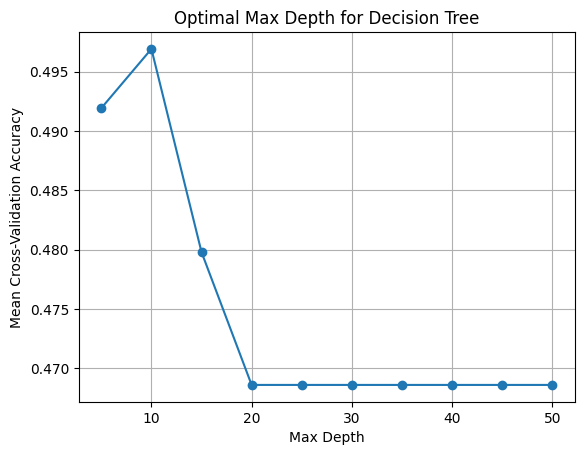

In [25]:
plt.plot(depths, mean_cv_scores_d, marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Optimal Max Depth for Decision Tree')
plt.grid(True)
plt.show()

In [26]:
best_depth = depths[np.argmax(mean_cv_scores_d)]
best_score = np.max(mean_cv_scores_d)

print(f"The optimal max_depth is {best_depth} with a mean CV accuracy of {best_score:.4f}")

The optimal max_depth is 10 with a mean CV accuracy of 0.4969


---

#### Optimal min_samples_split

In [27]:
min_samples_splits = range(2, 451, 50) 
mean_cv_scores_s = []

for split in min_samples_splits:
    clf = DecisionTree(min_samples_split=split, max_depth=10)
    cv_scores = cross_val_score(clf, X_encoded, y_cleaned, cv=3, scoring='accuracy',  n_jobs=-1)
    mean_cv_scores_s.append(np.mean(cv_scores))

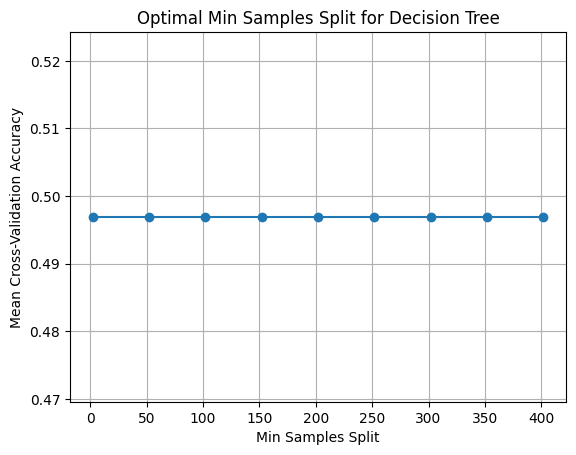

In [28]:
plt.plot(min_samples_splits, mean_cv_scores_s, marker='o')
plt.xlabel('Min Samples Split')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Optimal Min Samples Split for Decision Tree') 
plt.grid(True)
plt.show()

In [29]:
best_min_samples_splits = min_samples_splits[np.argmax(mean_cv_scores_s)]
best_score = np.max(mean_cv_scores_s)

print(f"The optimal Min Samples Split is {best_min_samples_splits} with a mean CV accuracy of {best_score:.4f}")

The optimal Min Samples Split is 2 with a mean CV accuracy of 0.4969


---

### Train the tree predictors

3 splitting criteria

- Gini Index: Measures the impurity of a node
- Entropy: Measures the amount of information gained from a split  -  Focuses on reducing uncertainty
- Chi-Squared Statistic: Measures the average squared difference between actual and predicted values 

---

2 stopping Criteria - here default values

- Maximum Depth: Stop splitting if the tree reaches a certain depth (max_depth=None default - allows the tree to grow until it perfectly classifies the training data... possibly leading to overfitting)
- Minimum Samples Split: Stop splitting if the number of samples in a node is less than a threshold (min_samples_split=2 default)


GINI

In [18]:
tree_gini = DecisionTree(splitting_criterion='gini', max_depth=10, min_samples_split=2)
tree_gini.fit(X_train, y_train)
    
y_train_pred_gini = tree_gini.predict(X_train)

ENTROPY

In [19]:
tree_entropy = DecisionTree(splitting_criterion='entropy', max_depth=10, min_samples_split=2)
tree_entropy.fit(X_train, y_train)
    
y_train_pred_entropy = tree_entropy.predict(X_train)

SQUARED ERROR

In [20]:
tree_squared_error = DecisionTree(splitting_criterion='squared_error', max_depth=10, min_samples_split=2)
tree_squared_error.fit(X_train, y_train)

y_train_pred_squared_error = tree_squared_error.predict(X_train)

#### Training error for binary classification

In [21]:
train_error_gini = zero_one_loss(y_train, y_train_pred_gini)
print(f"Training Error - Gini (0-1 loss): {train_error_gini:.4f}")

train_error_entropy = zero_one_loss(y_train, y_train_pred_entropy)
print(f"Training Error - Entropy (0-1 loss): {train_error_entropy:.4f}")

train_error_squared_error = zero_one_loss(y_train, y_train_pred_squared_error)
print(f"Training Error - Squared error (0-1 loss): {train_error_squared_error:.4f}")

Training Error - Gini (0-1 loss): 0.0137
Training Error - Entropy (0-1 loss): 0.1207
Training Error - Squared error (0-1 loss): 0.0137


Good with low training error 

#### Test error 
as an estimate for the risk (= performance of the predictor)

In [22]:
y_test_pred_gini = tree_gini.predict(X_test)
y_test_pred_entropy = tree_entropy.predict(X_test)
y_test_pred_squared_error = tree_squared_error.predict(X_test)

In [23]:
test_error_gini = zero_one_loss(y_test, y_test_pred_gini)
print(f"Test Error - Gini (0-1 loss): {test_error_gini:.4f}")

test_error_entropy = zero_one_loss(y_test, y_test_pred_entropy)
print(f"Test Error - Entropy (0-1 loss): {test_error_entropy:.4f}")

test_error_squared_error = zero_one_loss(y_test, y_test_pred_squared_error)
print(f"Test Error - Squared error (0-1 loss): {test_error_squared_error:.4f}")

Test Error - Gini (0-1 loss): 0.0160
Test Error - Entropy (0-1 loss): 0.1230
Test Error - Squared error (0-1 loss): 0.0160


Seems that there's no overfitting since training and test accuracy are similar

---

### Is there overfitting?


Regularization techniques to mitigate it:

- Hyperparameter tuning

- Cross Validation Score

- Validation curve

## Hyperparameter tuning

##### RandomizedSearchCV 
It searches for the best hyperparameters by randomly sampling a specified number of parameter combinations from the provided search space. 

In [30]:
hyperparam = {
    'criterion': ['gini', 'entropy', 'squared_error'],
    'max_depth': range(5, 51, 5),
    'min_samples_split': range(2, 451, 50)
}

In [31]:
tuned_tree = DecisionTree()  

random_search = RandomizedSearchCV(tuned_tree, param_distributions=hyperparam, n_iter=50, cv=5, n_jobs=-1)

random_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {random_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {random_search.best_score_:.4f}")   

Best Hyperparameters: {'min_samples_split': 2, 'max_depth': 40, 'criterion': 'gini'}
Best Cross-Validation Accuracy: 0.9993


In [32]:
y_pred_h = random_search.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_h)

print(f"Test accuracy: {accuracy}")

Test accuracy: 0.9995503597122302


Use cross_val_score to evaluate the performance of the model on the whole dataset

In [33]:
scores = cross_val_score(random_search, X_encoded, y_cleaned, cv=3,  n_jobs=-1)   
scores.mean()

0.46859121363370654

Since these parameters are already the result of RandomizedSearchCV, it's important to understand that even though they might represent the best found in your search, overfitting is still a potential issue due to the nature of the dataset, model complexity, and data split.

---

### Validation curves

- max_depth

/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


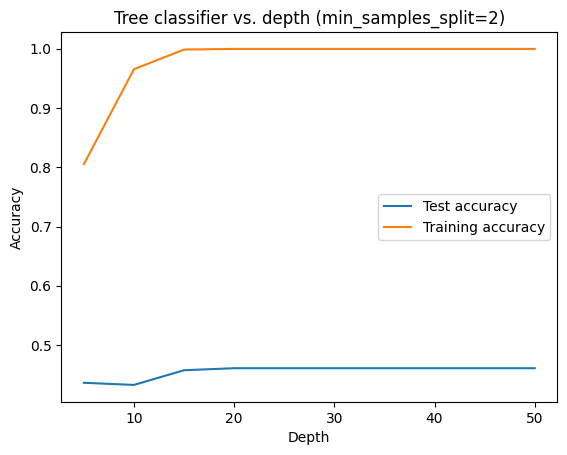

In [34]:
tun_tree = DecisionTree(splitting_criterion='gini', min_samples_split=2)
depths = np.arange(5, 51, 5) 

train_score, test_score = validation_curve(tun_tree, X_encoded, y_cleaned, param_name='max_depth', param_range=depths, cv=5, n_jobs=-1)


plt.title('Tree classifier vs. depth (min_samples_split=2)')
plt.plot(depths, np.mean(test_score, axis=1), label='Test accuracy')
plt.plot(depths, np.mean(train_score, axis=1), label='Training accuracy')

plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()


From the plot it's evident that there's overfitting (the model performs very well on training data but poorly on test data)

---

- min_samples_splits

/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (de

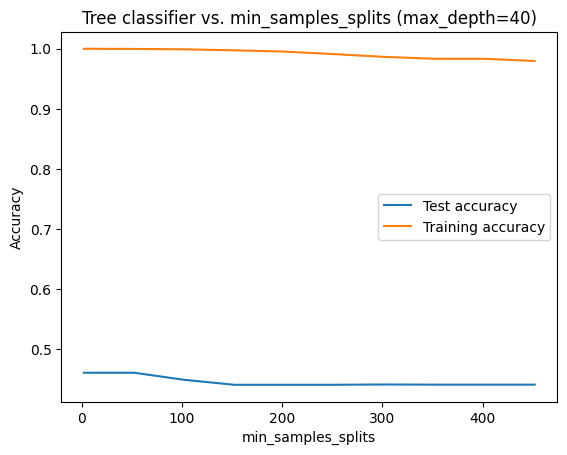

In [14]:
tune_tree = DecisionTree(splitting_criterion='gini', max_depth=40)
min_samples_splits = np.arange(2, 501, 50)  

train_score, test_score = validation_curve(tune_tree, X_encoded, y_cleaned, param_name='min_samples_split', param_range=min_samples_splits, cv=5, n_jobs=-1)


plt.title('Tree classifier vs. min_samples_splits (max_depth=40)')
plt.plot(min_samples_splits, np.mean(test_score, axis=1), label='Test accuracy')
plt.plot(min_samples_splits, np.mean(train_score, axis=1), label='Training accuracy')

plt.legend()
plt.xlabel('min_samples_splits')
plt.ylabel('Accuracy')
plt.show()

There's overfitting

---

## Random Forest

It combats overfitting by averaging multiple decision trees, each trained on a random subset of the data and features

In [32]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


random_forest = RandomForest(n_estimators=50, max_depth=40, min_samples_split=2)

random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with RandomForest: {accuracy:.4f}")

Accuracy with RandomForest: 0.9996


In [37]:
print(type(X_encoded), X_encoded.shape)  
print(type(y_cleaned), y_cleaned.shape) 

<class 'numpy.ndarray'> (22239, 84)
<class 'pandas.core.series.Series'> (22239,)


In [29]:
y_cleaned = y_cleaned.to_numpy()  

scores = cross_val_score(random_forest, X_encoded, y_cleaned, cv=3,  n_jobs=-1, error_score='raise')   
scores.mean()

/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f

0.5009218040379514

The performance of RandomForest classifier is slightly better than RandomizedSearchCV on DecisionTree classifier, indeed 0.5009 > 0.4686.

---

### Validation curves with RandomForest

- max_depth

/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/beatricecagnin/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (de

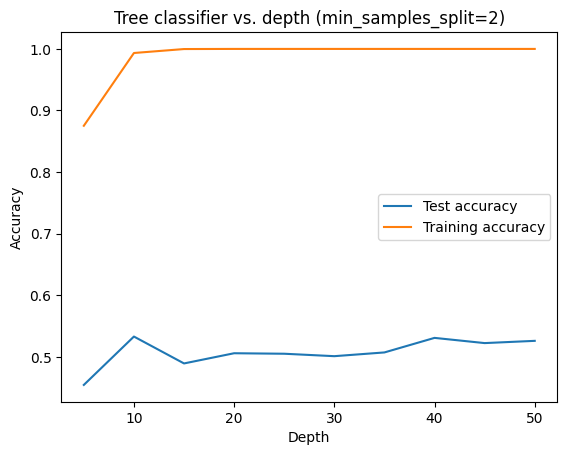

In [33]:
tun_tree_rf = RandomForest(n_estimators=10, min_samples_split=2)
depths = np.arange(5, 51, 5) 

train_score, test_score = validation_curve(tun_tree_rf, X_encoded, y_cleaned, param_name='max_depth', param_range=depths, cv=3, n_jobs=-1)


plt.title('Tree classifier vs. depth (min_samples_split=2)')
plt.plot(depths, np.mean(test_score, axis=1), label='Test accuracy')
plt.plot(depths, np.mean(train_score, axis=1), label='Training accuracy')

plt.legend()
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.show()


- min_samples_splits

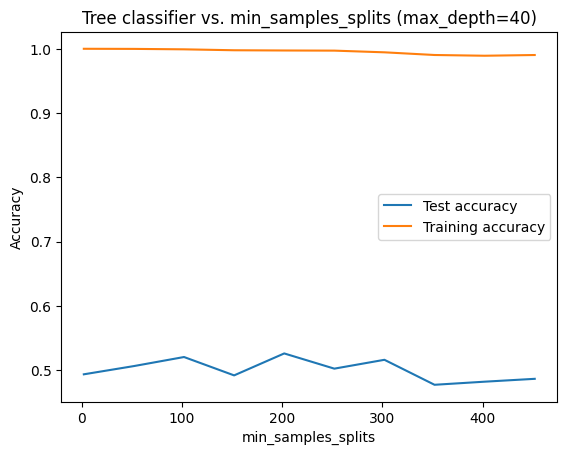

In [34]:
tune_tree_rf = RandomForest(n_estimators=10, max_depth=40)
min_samples_splits = np.arange(2, 501, 50)  

train_score, test_score = validation_curve(tune_tree_rf, X_encoded, y_cleaned, param_name='min_samples_split', param_range=min_samples_splits, cv=3, n_jobs=-1)


plt.title('Tree classifier vs. min_samples_splits (max_depth=40)')
plt.plot(min_samples_splits, np.mean(test_score, axis=1), label='Test accuracy')
plt.plot(min_samples_splits, np.mean(train_score, axis=1), label='Training accuracy')

plt.legend()
plt.xlabel('min_samples_splits')
plt.ylabel('Accuracy')
plt.show()